## ResNet 1x with Ctrl Tanh() 

In [1]:
# %% [markdown]
# ## ResNet with Ctrl Tanh() 
# 
# This repository provides a custom ResNet-style model trained on the CIFAR-10 dataset, demonstrating how to replace standard ReLU activations with a custom hyperbolic tangent (\tanh) function, then use Captum **Saliency** to visualize explanation maps.

# %%
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import latexify
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.resnet import ResNet, Bottleneck

# Captum: now using Saliency instead of LRP
from captum.attr import Saliency


/opt/anaconda3/envs/pytorch_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###############################################
# Plot asymetric π/4 Tanh function
###############################################
@latexify.function
def CustomTanhPrint(x):
    return (e**x - e**-x) /( e**x + e**-x)

print(CustomTanhPrint)
CustomTanhPrint


\mathrm{CustomTanhPrint}(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}


In [3]:
################################################################################
# 1) Define Custom π/4 Tanh Activation
################################################################################
class CustomTanh(nn.Module):
    """
    Custom Tanh activation using the explicit formula:
        tanh(x) = [ e^x - e^-x ] / [ e^x + e^-x ]
    """
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return (x.exp() - (-x).exp()) / (x.exp() + (-x).exp())

In [4]:
################################################################################
# 2) Define TanhBottleneck Block (Replaces ReLU with Custom Tanh)
################################################################################
class TanhBottleneck(Bottleneck):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        # 1) conv1 -> bn1 -> tanh
        out = self.conv1(x)
        out = self.bn1(out)
        out = (out.exp() - (-out).exp()) / (out.exp() + (-out).exp())  # <--- use 'out'

        # 2) conv2 -> bn2 -> tanh
        out = self.conv2(out)
        out = self.bn2(out)
        out = (out.exp() - (-out).exp()) / (out.exp() + (-out).exp())  # <--- use 'out'

        # 3) conv3 -> bn3
        out = self.conv3(out)
        out = self.bn3(out)

        # Downsampling if needed
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add skip connection
        out += identity

        # Final tanh after the addition
        out = (out.exp() - (-out).exp()) / (out.exp() + (-out).exp())  # <--- use 'out'

        return out

In [5]:
################################################################################
# 3) Create a Custom ResNet Class Using TanhBottleneck
################################################################################
class ResNetTanh(ResNet):
    def __init__(self, layers, num_classes=10):
        super().__init__(
            block=TanhBottleneck,
            layers=layers,
            num_classes=num_classes
        )
    def forward(self, x):
        return super().forward(x)

def resnet50_tanh(double_depth=False, num_classes=10):
    """
    Build a ResNet-50-like model with π/4 Tanh activation.
    - If double_depth=True, doubles each stage from [3,4,6,3] to [6,8,12,6].
    """
    layers = [6, 8, 12, 6] if double_depth else [3, 4, 6, 3]
    return ResNetTanh(layers=layers, num_classes=num_classes)


In [6]:
################################################################################
# 4) Data Loading: CIFAR-10
################################################################################
os.makedirs('./cifar_data', exist_ok=True)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(
    root="./cifar_data",
    train=True,
    download=True,
    transform=transform_train
)
test_dataset = datasets.CIFAR10(
    root="./cifar_data",
    train=False,
    download=True,
    transform=transform_test
)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
################################################################################
# 5) Instantiate Model, Loss, Optimizer
################################################################################
device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(f"Using device: {device}")

model = resnet50_tanh(double_depth=False, num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: mps


In [8]:
################################################################################
# 6) Training & Evaluation Functions
################################################################################
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [9]:
################################################################################
# 7) Main Training Loop
################################################################################
num_epochs = 20  # For demonstration, keep it short
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

Epoch 1/20 Train Loss: 1.8791 Acc: 30.60% | Test Loss: 1.6999 Acc: 36.46%
Epoch 2/20 Train Loss: 1.6015 Acc: 41.22% | Test Loss: 1.6374 Acc: 39.62%
Epoch 3/20 Train Loss: 1.4381 Acc: 47.36% | Test Loss: 1.5918 Acc: 43.26%
Epoch 4/20 Train Loss: 1.3064 Acc: 52.58% | Test Loss: 1.3623 Acc: 49.44%
Epoch 5/20 Train Loss: 1.1675 Acc: 57.87% | Test Loss: 1.1739 Acc: 58.21%
Epoch 6/20 Train Loss: 1.0368 Acc: 62.94% | Test Loss: 1.0702 Acc: 61.07%
Epoch 7/20 Train Loss: 0.9460 Acc: 66.18% | Test Loss: 1.0421 Acc: 63.26%
Epoch 8/20 Train Loss: 0.8562 Acc: 69.64% | Test Loss: 0.9607 Acc: 66.82%
Epoch 9/20 Train Loss: 0.7794 Acc: 72.51% | Test Loss: 0.9415 Acc: 67.31%
Epoch 10/20 Train Loss: 0.7188 Acc: 74.70% | Test Loss: 0.7668 Acc: 73.18%
Epoch 11/20 Train Loss: 0.6558 Acc: 76.92% | Test Loss: 0.7796 Acc: 73.17%
Epoch 12/20 Train Loss: 0.6061 Acc: 78.88% | Test Loss: 0.7861 Acc: 72.86%
Epoch 13/20 Train Loss: 0.5599 Acc: 80.41% | Test Loss: 0.7047 Acc: 75.48%
Epoch 14/20 Train Loss: 0.5175 Acc

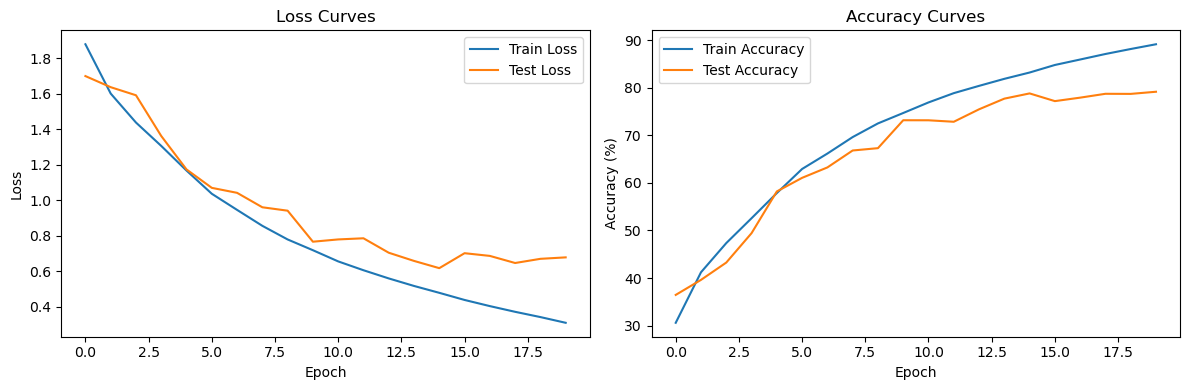

In [10]:
###############################################
# 8) Plot the training curves
###############################################
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
################################################################################
# Save Model Weights
################################################################################
torch.save(model.state_dict(), "resnet50_conv_tanh_cifar10.pt")
print("Model saved to resnet50_tanh_cifar10.pt")

Model saved to resnet50_tanh_cifar10.pt


Ground Truth: 0 | Predicted: 0
Ground Truth: 0 | Predicted (index): 0 | Predicted (label): airplane


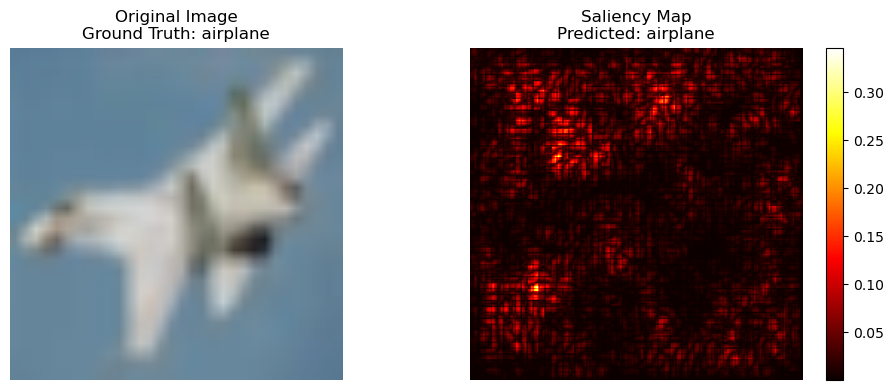

In [41]:
################################################################################
# 9) Saliency Analysis (Captum) - as an alternative to LRP
################################################################################
# We'll compute a saliency map on a single sample from the test set.
saliency = Saliency(model)

# CIFAR-10 class names:
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]


# Get one batch from the test loader
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Focus on a single image
img_index = 10  # pick any valid index within the batch <<<<<<<<<<<<<<<<<<<<<!!!!!!!!!!!!!!!!!!!
single_img = images[img_index].unsqueeze(0)   
single_label = labels[img_index].item()

model.eval()
with torch.no_grad():
    output = model(single_img)
predicted_class = output.argmax(dim=1).item()

print("Ground Truth:", single_label, "| Predicted:", predicted_class)


with torch.no_grad():
    output = model(single_img)
predicted_class = output.argmax(dim=1).item()
predicted_label_str = class_names[predicted_class]
print("Ground Truth:", single_label, "| Predicted (index):", predicted_class,
      "| Predicted (label):", predicted_label_str)

# For saliency, we need gradients wrt input:
single_img.requires_grad_()

# Compute saliency attributions for the predicted class
attr = saliency.attribute(single_img, target=predicted_class)  # [1,3,224,224]

# Convert to numpy for visualization
attr = attr.detach().cpu().numpy()[0]  # shape [3,224,224]
attr_sum = np.sum(attr, axis=0)        # sum over the channels => [224,224]

# (A) Show the original image
original_img = single_img[0].detach().cpu().numpy()  # shape [3,224,224]
original_img = np.transpose(original_img, (1,2,0))   # => [224,224,3]

# Denormalize for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
original_img = std * original_img + mean
original_img = np.clip(original_img, 0, 1)

plt.figure(figsize=(10,4))

# (A) Original Image
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title(f"Original Image\nGround Truth: {class_names[single_label]}")
plt.axis("off")

# (B) Saliency Map
plt.subplot(1,2,2)
plt.imshow(attr_sum, cmap='hot')
plt.title(f"Saliency Map\nPredicted: {predicted_label_str}")
plt.axis("off")
plt.colorbar()

plt.tight_layout()
plt.show()